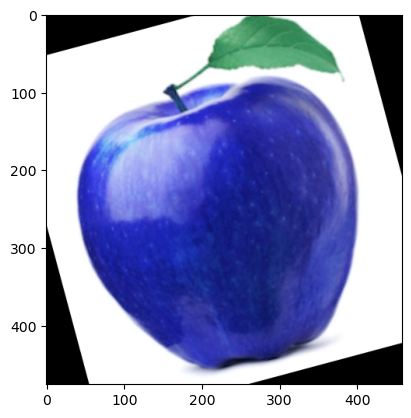

Types of fruits found:  6


In [1]:
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt
import os
import cv2 as cv
from tqdm import tqdm

#loading images from path
DATADIR = 'C:/Users/divya/Desktop/set 2/archive2/dataset/train'
CATEGORIES = ["freshapples","freshbanana","freshoranges","rottenapples","rottenbanana","rottenoranges"]
for category in CATEGORIES:
    path = os.path.join(DATADIR, category)
    for img in os.listdir(path):
        img_array = cv.imread(os.path.join(path,img))
        #,cv2.IMREAD_GRAYSCALE
        plt.imshow(img_array)
        plt.show()
        break
    break
#print (room_types)  #what kinds of rooms are in this dataset

print("Types of fruits found: ", len(CATEGORIES))

In [2]:
IMG_SIZE = 100
batch_size = 100
img_height = 100
img_width = 100

In [3]:
#building our training data
training_data = []

def create_training_data():
    for category in CATEGORIES:  # do fruits

        path = os.path.join(DATADIR,category)  # create path to fruits
        class_num = CATEGORIES.index(category)  # get the classification  (0 ,1,2,3,4,5,6) different number donate different category of fruit

        for img in tqdm(os.listdir(path)):  # iterate over each image per fruits
            try:
                img_array = cv.imread(os.path.join(path,img) ,cv.IMREAD_GRAYSCALE)  # convert to array
                new_array = cv.resize(img_array, (IMG_SIZE, IMG_SIZE))  # resize to normalize data size
                training_data.append([new_array, class_num])  # add this to our training_data
            except Exception as e:  # in the interest in keeping the output clean...
                pass        

create_training_data()

image_count = len(training_data)

100%|██████████████████████████████████████████████████████████████████████████████| 1595/1595 [00:31<00:00, 50.23it/s]


In [4]:
# Build a dataframe        
fruits_df = pd.DataFrame(data=training_data, columns=['fruits type', 'image'])
print(len(fruits_df))

10901


In [5]:
# Build a dataframe        
fruits_df = pd.DataFrame(data=training_data, columns=['fruits type', 'image'])

In [6]:
#Assigning labels and features
X =[]
y =[]
for features, label in training_data:
    X.append(features)
    y.append(label)
X = np.array(X).reshape(-1, IMG_SIZE, IMG_SIZE, 1)

In [7]:
# Transform the image array to a numpy type
X = np.array(X)
X.shape 
X = np.array(X)
y=np.array(y)

In [8]:
#creating own model
#Normalising X and converting labels to categorical data
from keras.utils import np_utils
X = X.astype('float32')
X /= 255
Y = np_utils.to_categorical(y,6)
#print(Y[100])
print(Y.shape)

(10901, 6)


In [9]:
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
X, Y = shuffle(X, Y, random_state=1)
train_x, test_x, train_y, test_y = train_test_split(X, Y, test_size=0.3, random_state=415)

#inpect the shape of the training and testing.
print(train_x.shape)
print(train_y.shape)
print(test_x.shape)
print(test_y.shape)

(7630, 100, 100, 1)
(7630, 6)
(3271, 100, 100, 1)
(3271, 6)


In [10]:
from keras import layers
from keras.layers import Input, Add, Dense, Activation, ZeroPadding2D, BatchNormalization, Flatten, Conv2D, AveragePooling2D, MaxPooling2D, GlobalMaxPooling2D
from keras.models import Model, load_model
from keras.preprocessing import image
from keras.utils import layer_utils
from keras.utils.data_utils import get_file
from keras.applications.imagenet_utils import preprocess_input
import pydot
from IPython.display import SVG
from keras.utils.vis_utils import model_to_dot
from keras.utils import plot_model

from keras.initializers import glorot_uniform
import scipy.misc
from matplotlib.pyplot import imshow

from keras.initializers import glorot_uniform
from keras.layers import Input, Add, Dense, Activation, ZeroPadding2D, BatchNormalization, Flatten, Conv2D, AveragePooling2D, MaxPooling2D, GlobalMaxPooling2D

In [11]:
# x is input, y=F(x)
# identity block simply means input should be equal to output. 
#  y = x + F(x)   the layers in a traditional network are learning the true output H(x)
# F(x) = y - x   the layers in a residual network are learning the residual F(x)
# Hence, the name: Residual Block.
def identity_block(A, f, filters, stage, block):
    """ 
    Arguments:
    A -- input of shape (m, height, width, channel)
    f -- shape of the middle CONV's window for the main path
    filters -- python list of integers, defining the number of filters in the CONV layers of the main path
    stage -- integer, used to name the layers, depending on their position in the network
    block -- string/character, used to name the layers, depending on their position in the network
    
    Returns:
    A -- output of the identity block, tensor of shape (n_H, n_W, n_C)
    """  
    # defining name basis
    conv_name_base = 'res' + str(stage) + block + '_branch'
    bn_name_base = 'bn' + str(stage) + block + '_branch'
    
    # Retrieve Filters
    F1, F2, F3 = filters
    
    # Saving the input value.we need this later to add to the output. 
    A_shortcut = A
     # First component of main path
    A = Conv2D(filters = F1, kernel_size = (1, 1), strides = (1,1), padding = 'valid', name = conv_name_base + '2a')(A)
    A = BatchNormalization(axis = 3, name = bn_name_base + '2a')(A)
    A = Activation('relu')(A)
    
    # Second component of main path (≈3 lines)
    A = Conv2D(filters = F2, kernel_size = (f, f), strides = (1,1), padding = 'same', name = conv_name_base + '2b')(A)
    A = BatchNormalization(axis = 3, name = bn_name_base + '2b')(A)
    A = Activation('relu')(A)

    # Third component of main path (≈2 lines)
    A = Conv2D(filters = F3, kernel_size = (1, 1), strides = (1,1), padding = 'valid', name = conv_name_base + '2c')(A)
    A = BatchNormalization(axis = 3, name = bn_name_base + '2c')(A)

    # Final step: Add shortcut value to main path, and pass it through a RELU activation 
    A = Add()([A, A_shortcut])
    A = Activation('relu')(A)    
    
    return A

In [12]:
def convolutional_block(A, f, filters, stage, block, s = 2):  
    # defining name basis
    conv_name_base = 'res' + str(stage) + block + '_branch'
    bn_name_base = 'bn' + str(stage) + block + '_branch' 
    # Retrieve Filters
    F1, F2, F3 = filters  
    # Save the input value
    A_shortcut = A
    # First layer 
    A = Conv2D(F1, (1, 1), strides = (s,s), name = conv_name_base + '2a')(A) # 1,1 is filter size
    A = BatchNormalization(axis = 3, name = bn_name_base + '2a')(A)  # normalization on channels
    A = Activation('relu')(A)   
    # Second layer  (f,f)=3*3 filter by default
    A = Conv2D(filters = F2, kernel_size = (f, f), strides = (1,1), padding = 'same', name = conv_name_base + '2b')(A)
    A = BatchNormalization(axis = 3, name = bn_name_base + '2b')(A)
    A = Activation('relu')(A)
    # Third layer
    A = Conv2D(filters = F3, kernel_size = (1, 1), strides = (1,1), padding = 'valid', name = conv_name_base + '2c')(A)
    A = BatchNormalization(axis = 3, name = bn_name_base + '2c')(A)
     ##### SHORTCUT PATH #### 
    A_shortcut = Conv2D(filters = F3, kernel_size = (1, 1), strides = (s,s), padding = 'valid', name = conv_name_base + '1')(A_shortcut)
    A_shortcut = BatchNormalization(axis = 3, name = bn_name_base + '1')(A_shortcut)

    # Final step: Add shortcut value here, and pass it through a RELU activation 
    A = Add()([A, A_shortcut])
    A = Activation('relu')(A)
       
    return A

In [13]:
#creating Resnet 50
#Each ResNet block is either 2 layer deep
def ResNet50(input_shape=(100,100,1), classes=7):
    """
    Implementation of the ResNet50 architecture:
    CONV2D -> BATCHNORM -> RELU -> MAAPOOL -> CONVBLOCK -> IDBLOCK*2 -> CONVBLOCK -> IDBLOCK*3
    -> CONVBLOCK -> IDBLOCK*5 -> CONVBLOCK -> IDBLOCK*2 -> AVGPOOL -> TOPLAYER

    """
    # Define the input as a tensor with shape input_shape
    A_input = Input(input_shape)
    # Zero-Padding
    A = ZeroPadding2D((3, 3))(A_input) #3,3 padding
    # Stage 1
    A = Conv2D(64, (7, 7), strides=(2, 2), name='conv1')(A) #64 filters of 7*7 
    A = BatchNormalization(axis=3, name='bn_conv1')(A) #batch norm applied on channels
    A = Activation('relu')(A)
    A = MaxPooling2D((3, 3), strides=(2, 2))(A) #window size is 3*3
    # Stage 2
    A = convolutional_block(A, f=3, filters=[64, 64, 256], stage=2, block='a', s=1)
    # convolutional_block is a function defined above. Convolutional_block have 3 layers.
    #filters=[64, 64, 256] first 64 is for 1st layer and 2nd 64 is for 2nd layer and 256 is for 3rd layer of convultional block   
    # below are the conv layers from convolutional_block function
    #A = Conv2D(F1, (1, 1), strides = (s,s), name = conv_name_base + '2a')(A)
    #A = Conv2D(F2, kernel_size = (f, f), strides = (1,1), padding = 'same', name = conv_name_base + '2b')(A)
    #A = Conv2D(F3, (1, 1), strides = (s,s), name = conv_name_base + '2a')(A)
    A = identity_block(A, 3, [64, 64, 256], stage=2, block='b') 
    #A = Conv2D(filters = F1, kernel_size = (1, 1), strides = (1,1), padding = 'valid', name = conv_name_base + '2a')(A)
    #A = Conv2D(filters = F2, kernel_size = (f, f), strides = (1,1), padding = 'same', name = conv_name_base + '2b')(A)
    #A = Conv2D(filters = F3, kernel_size = (1, 1), strides = (1,1), padding = 'valid', name = conv_name_base + '2c')(A) 
    A = identity_block(A, 3, [64, 64, 256], stage=2, block='c')
    #A = Conv2D(filters = F1, kernel_size = (1, 1), strides = (1,1), padding = 'valid', name = conv_name_base + '2a')(A)
    #A = Conv2D(filters = F2, kernel_size = (f, f), strides = (1,1), padding = 'same', name = conv_name_base + '2b')(A)
    #A = Conv2D(filters = F3, kernel_size = (1, 1), strides = (1,1), padding = 'valid', name = conv_name_base + '2c')(A)
    ### START CODE HERE ###
    # Stage 3 
    A = convolutional_block(A, f = 3, filters = [128, 128, 512], stage = 3, block='a', s = 2)
    A = identity_block(A, 3, [128, 128, 512], stage=3, block='b')
    A = identity_block(A, 3, [128, 128, 512], stage=3, block='c')
    A = identity_block(A, 3, [128, 128, 512], stage=3, block='d')

    # Stage 4 
    A = convolutional_block(A, f = 3, filters = [256, 256, 1024], stage = 4, block='a', s = 2)
    A = identity_block(A, 3, [256, 256, 1024], stage=4, block='b')
    A = identity_block(A, 3, [256, 256, 1024], stage=4, block='c')
    A = identity_block(A, 3, [256, 256, 1024], stage=4, block='d')
    A = identity_block(A, 3, [256, 256, 1024], stage=4, block='e')
    A = identity_block(A, 3, [256, 256, 1024], stage=4, block='f')

    # Stage 5 
    A = convolutional_block(A, f = 3, filters = [512, 512, 2048], stage = 5, block='a', s = 2)
    A = identity_block(A, 3, [512, 512, 2048], stage=5, block='b')
    A = identity_block(A, 3, [512, 512, 2048], stage=5, block='c')

    # AVGPOOL 
    A = AveragePooling2D((2,2), name="avg_pool")(A)
     ### END CODE HERE ###
    # output layer
    A = Flatten()(A)
    A = Dense(classes, activation='softmax', name='fc' + str(classes), kernel_initializer = glorot_uniform(seed=0))(A)    
    # Create model
    model1 = Model(inputs = A_input, outputs = A, name='ResNet50')

    return model1

In [14]:
model1 = ResNet50(input_shape = (100,100,1), classes = 6)

In [15]:
model1.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [16]:
model1.summary()

Model: "ResNet50"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 100, 100, 1  0           []                               
                                )]                                                                
                                                                                                  
 zero_padding2d (ZeroPadding2D)  (None, 106, 106, 1)  0          ['input_1[0][0]']                
                                                                                                  
 conv1 (Conv2D)                 (None, 50, 50, 64)   3200        ['zero_padding2d[0][0]']         
                                                                                                  
 bn_conv1 (BatchNormalization)  (None, 50, 50, 64)   256         ['conv1[0][0]']           

 res2c_branch2c (Conv2D)        (None, 24, 24, 256)  16640       ['activation_8[0][0]']           
                                                                                                  
 bn2c_branch2c (BatchNormalizat  (None, 24, 24, 256)  1024       ['res2c_branch2c[0][0]']         
 ion)                                                                                             
                                                                                                  
 add_2 (Add)                    (None, 24, 24, 256)  0           ['bn2c_branch2c[0][0]',          
                                                                  'activation_6[0][0]']           
                                                                                                  
 activation_9 (Activation)      (None, 24, 24, 256)  0           ['add_2[0][0]']                  
                                                                                                  
 res3a_bra

                                                                  'activation_15[0][0]']          
                                                                                                  
 activation_18 (Activation)     (None, 12, 12, 512)  0           ['add_5[0][0]']                  
                                                                                                  
 res3d_branch2a (Conv2D)        (None, 12, 12, 128)  65664       ['activation_18[0][0]']          
                                                                                                  
 bn3d_branch2a (BatchNormalizat  (None, 12, 12, 128)  512        ['res3d_branch2a[0][0]']         
 ion)                                                                                             
                                                                                                  
 activation_19 (Activation)     (None, 12, 12, 128)  0           ['bn3d_branch2a[0][0]']          
          

 bn4c_branch2a (BatchNormalizat  (None, 6, 6, 256)   1024        ['res4c_branch2a[0][0]']         
 ion)                                                                                             
                                                                                                  
 activation_28 (Activation)     (None, 6, 6, 256)    0           ['bn4c_branch2a[0][0]']          
                                                                                                  
 res4c_branch2b (Conv2D)        (None, 6, 6, 256)    590080      ['activation_28[0][0]']          
                                                                                                  
 bn4c_branch2b (BatchNormalizat  (None, 6, 6, 256)   1024        ['res4c_branch2b[0][0]']         
 ion)                                                                                             
                                                                                                  
 activatio

                                                                                                  
 res4f_branch2c (Conv2D)        (None, 6, 6, 1024)   263168      ['activation_38[0][0]']          
                                                                                                  
 bn4f_branch2c (BatchNormalizat  (None, 6, 6, 1024)  4096        ['res4f_branch2c[0][0]']         
 ion)                                                                                             
                                                                                                  
 add_12 (Add)                   (None, 6, 6, 1024)   0           ['bn4f_branch2c[0][0]',          
                                                                  'activation_36[0][0]']          
                                                                                                  
 activation_39 (Activation)     (None, 6, 6, 1024)   0           ['add_12[0][0]']                 
          

 add_15 (Add)                   (None, 3, 3, 2048)   0           ['bn5c_branch2c[0][0]',          
                                                                  'activation_45[0][0]']          
                                                                                                  
 activation_48 (Activation)     (None, 3, 3, 2048)   0           ['add_15[0][0]']                 
                                                                                                  
 avg_pool (AveragePooling2D)    (None, 1, 1, 2048)   0           ['activation_48[0][0]']          
                                                                                                  
 flatten (Flatten)              (None, 2048)         0           ['avg_pool[0][0]']               
                                                                                                  
 fc6 (Dense)                    (None, 6)            12294       ['flatten[0][0]']                
          

In [17]:
import tensorflow as tf
model1.fit(train_x, train_y,batch_size=batch_size,epochs=12,validation_data=(test_x, test_y),shuffle=True,callbacks=[tf.keras.callbacks.CSVLogger('hisr.csv')]) 

Epoch 1/12
77/77 [==============================] - 963s 12s/step - loss: 1.6320 - accuracy: 0.5615 - val_loss: 3.2574 - val_accuracy: 0.1489
Epoch 2/12
77/77 [==============================] - 956s 12s/step - loss: 0.6015 - accuracy: 0.7779 - val_loss: 4.7146 - val_accuracy: 0.2504
Epoch 3/12
77/77 [==============================] - 936s 12s/step - loss: 0.4703 - accuracy: 0.8275 - val_loss: 3.5394 - val_accuracy: 0.3106
Epoch 4/12
77/77 [==============================] - 969s 13s/step - loss: 0.3414 - accuracy: 0.8790 - val_loss: 3.2155 - val_accuracy: 0.2617
Epoch 5/12
77/77 [==============================] - 951s 12s/step - loss: 0.2694 - accuracy: 0.9033 - val_loss: 2.6759 - val_accuracy: 0.3494
Epoch 6/12
77/77 [==============================] - 917s 12s/step - loss: 0.2327 - accuracy: 0.9185 - val_loss: 2.9784 - val_accuracy: 0.3647
Epoch 7/12
77/77 [==============================] - 863s 11s/step - loss: 0.4107 - accuracy: 0.8675 - val_loss: 3.3632 - val_accuracy: 0.4197
Epoch 

In [18]:
model1.save('saved_models/model1.hdf5')

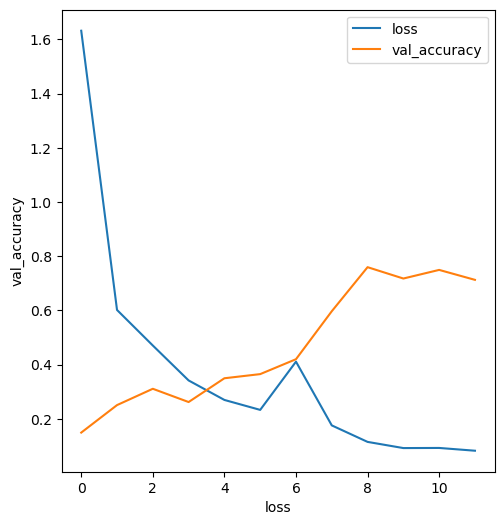

In [19]:
#Evaluate the Model
history = pd.read_csv('hisr.csv') 
history.head()
plt.figure(figsize=(19,6))
plt.subplot(131)
plt.plot(history.epoch, history.loss, label="loss")
plt.plot(history.epoch, history.val_accuracy, label="val_accuracy")
plt.xlabel('loss')
plt.ylabel('val_accuracy')
plt.legend()

In [20]:
#observing its classification report and confusion matrix
from sklearn.metrics import accuracy_score,classification_report,confusion_matrix
#predict
y_pred=model1.predict(test_x)
y_pred=np.argmax(y_pred,axis=1)
test_y_arg=np.argmax(test_y,axis=1)
Y_pred = np.argmax(model1.predict(test_x),axis=1)

103/103 [==============================] - 82s 799ms/step


In [21]:
model2 = tf.keras.Sequential([
    tf.keras.layers.Conv2D(96, (3,3), padding='same', activation=tf.nn.relu,input_shape=(100, 100, 1)),
    tf.keras.layers.MaxPooling2D((2, 2), strides=3),
    tf.keras.layers.Conv2D(256, (3,3), padding='same', activation=tf.nn.relu),
    tf.keras.layers.MaxPooling2D((2, 2), strides=3),
    tf.keras.layers.Conv2D(384, (3,3), padding='same', activation=tf.nn.relu),
    tf.keras.layers.MaxPooling2D((2, 2), strides=3),
    tf.keras.layers.Conv2D(384, (3,3), padding='same', activation=tf.nn.relu),
    tf.keras.layers.MaxPooling2D((2, 2), strides=3),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(1024, activation=tf.nn.relu),
    tf.keras.layers.Dense(6,  activation=tf.nn.softmax)
])

In [22]:
model2.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 100, 100, 96)      960       
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 33, 33, 96)       0         
 2D)                                                             
                                                                 
 conv2d_1 (Conv2D)           (None, 33, 33, 256)       221440    
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 11, 11, 256)      0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 11, 11, 384)       885120    
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 4, 4, 384)        0

In [23]:
model2.compile(optimizer='Adam',loss='categorical_crossentropy',metrics=['accuracy'])
model2.fit(train_x, train_y, batch_size = 32,verbose=1, epochs = 12,validation_split = 0.3, callbacks=[tf.keras.callbacks.CSVLogger('his.csv')])


Epoch 1/12
167/167 [==============================] - 236s 1s/step - loss: 1.4238 - accuracy: 0.4014 - val_loss: 0.9892 - val_accuracy: 0.5924
Epoch 2/12
167/167 [==============================] - 234s 1s/step - loss: 0.9847 - accuracy: 0.6057 - val_loss: 0.7823 - val_accuracy: 0.6828
Epoch 3/12
167/167 [==============================] - 236s 1s/step - loss: 0.8219 - accuracy: 0.6738 - val_loss: 0.7016 - val_accuracy: 0.7296
Epoch 4/12
167/167 [==============================] - 235s 1s/step - loss: 0.6811 - accuracy: 0.7371 - val_loss: 0.6494 - val_accuracy: 0.7431
Epoch 5/12
167/167 [==============================] - 253s 2s/step - loss: 0.6604 - accuracy: 0.7448 - val_loss: 0.5621 - val_accuracy: 0.7872
Epoch 6/12
167/167 [==============================] - 245s 1s/step - loss: 0.5406 - accuracy: 0.7911 - val_loss: 0.5122 - val_accuracy: 0.8065
Epoch 7/12
167/167 [==============================] - 253s 2s/step - loss: 0.5081 - accuracy: 0.8073 - val_loss: 0.6049 - val_accuracy: 0.7737

In [24]:
model2.save('saved_model/model2.hdf5')

In [25]:
#Evaluate the Model
history = pd.read_csv('his.csv') 
history.head()

,epoch,accuracy,loss,val_accuracy,val_loss
0,0,0.401423,1.423763,0.592398,0.989193
1,1,0.605692,0.984704,0.682831,0.782290
2,2,0.673844,0.821865,0.729576,0.701619
3,3,0.737128,0.681092,0.743119,0.649433
4,4,0.744804,0.660373,0.787243,0.562052


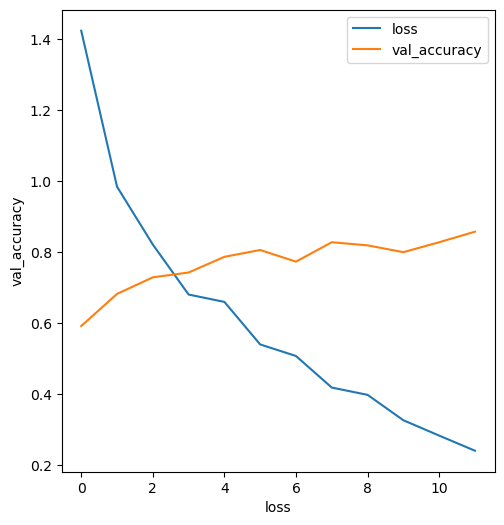

In [26]:
plt.figure(figsize=(19,6))
plt.subplot(131)
plt.plot(history.epoch, history.loss, label="loss")
plt.plot(history.epoch, history.val_accuracy, label="val_accuracy")
plt.xlabel('loss')
plt.ylabel('val_accuracy')
plt.legend()

In [27]:
from keras.models import Model
rounded_predictions = model2.predict(test_x, batch_size=32, verbose=0)
rounded_predictions[1]

array([9.5396203e-01, 4.9053906e-08, 1.3464539e-03, 4.3700613e-02,
       5.1525021e-06, 9.8565489e-04], dtype=float32)

In [28]:
#Accuracy and Score of model
score = model2.evaluate(test_x, test_y, verbose = 1 )
print("Test Score: ", score[0])
print("Test accuracy: ", score[1]*100,'%')

103/103 [==============================] - 33s 322ms/step - loss: 0.4381 - accuracy: 0.8508
Test Score:  0.4380894899368286
Test accuracy:  85.0810170173645 %


In [29]:
#Accuracy and Score of model
#score = model.evaluate(X_test, y_test, verbose = 1 )
#print("Test Score: ", score[0])
#print("Test accuracy: ", score[1]*100,'%')
#observing its classification report and confusion matrix
from sklearn.metrics import accuracy_score,classification_report,confusion_matrix
#predict
y_pred=model2.predict(test_x)
y_pred=np.argmax(y_pred,axis=1)
test_y_arg=np.argmax(test_y,axis=1)

103/103 [==============================] - 33s 324ms/step


This model consists of:

A Conv2D layer with 32 filters and a kernel size of (3, 3) followed by a ReLU activation function. This layer takes in the input shape of (100, 100, 3).
A MaxPooling2D layer that performs max pooling with pool size of (2, 2) to reduce the spatial dimensions.
A Dropout layer with a rate of 0.25 to prevent overfitting.
Another Conv2D layer with 64 filters and a kernel size of (3, 3), followed by a ReLU activation function.
Another MaxPooling2D layer with pool size of (2, 2) and a Dropout layer with a rate of 0.25.
Another Conv2D layer with 128 filters and a kernel size of (3, 3), followed by a ReLU activation function.
Another MaxPooling2D layer with pool size of (2, 2) and a Dropout layer with a rate of 0.25.
A Flatten layer to flatten the output from the convolutional layers into a 1D vector.
Two dense (Dense) layers with 512 and 256 neurons respectively, using ReLU activation functions and a Dropout layer with a rate of 0.5.
A final dense (Dense) layer with 10 neurons and a Softmax activation function.
Finally, we compile the model using the Adam optimizer, categorical cross-entropy loss function, and accuracy metric.

With this model architecture, you can experiment with different hyperparameters and train the model on your dataset to achieve higher accuracy.

In [30]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout

# Define the model3 architecture
model3 = Sequential()
model3.add(Conv2D(32, kernel_size=(3, 3), activation='relu', input_shape=(100, 100, 1)))
model3.add(MaxPooling2D(pool_size=(2, 2)))
model3.add(Dropout(0.25))
model3.add(Conv2D(64, kernel_size=(3, 3), activation='relu'))
model3.add(MaxPooling2D(pool_size=(2, 2)))
model3.add(Dropout(0.25))
model3.add(Conv2D(128, kernel_size=(3, 3), activation='relu'))
model3.add(MaxPooling2D(pool_size=(2, 2)))
model3.add(Dropout(0.25))
model3.add(Flatten())
model3.add(Dense(512, activation='relu'))
model3.add(Dropout(0.5))
model3.add(Dense(256, activation='relu'))
model3.add(Dropout(0.5))
model3.add(Dense(6, activation='softmax'))

# Compile the model3
model3.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [31]:
history3=model3.fit(train_x, train_y,batch_size=batch_size,epochs=12,validation_data=(test_x, test_y),shuffle=True,callbacks=[tf.keras.callbacks.CSVLogger('hisr3.csv')]) 

Epoch 1/12
77/77 [==============================] - 99s 1s/step - loss: 1.6050 - accuracy: 0.3307 - val_loss: 1.3251 - val_accuracy: 0.4497
Epoch 2/12
77/77 [==============================] - 97s 1s/step - loss: 1.1054 - accuracy: 0.5497 - val_loss: 1.0618 - val_accuracy: 0.5888
Epoch 3/12
77/77 [==============================] - 97s 1s/step - loss: 0.9216 - accuracy: 0.6367 - val_loss: 0.7892 - val_accuracy: 0.6970
Epoch 4/12
77/77 [==============================] - 99s 1s/step - loss: 0.8058 - accuracy: 0.6895 - val_loss: 0.8258 - val_accuracy: 0.6824
Epoch 5/12
77/77 [==============================] - 97s 1s/step - loss: 0.6812 - accuracy: 0.7405 - val_loss: 0.7372 - val_accuracy: 0.7172
Epoch 6/12
77/77 [==============================] - 97s 1s/step - loss: 0.6531 - accuracy: 0.7465 - val_loss: 0.7608 - val_accuracy: 0.7129
Epoch 7/12
77/77 [==============================] - 97s 1s/step - loss: 0.5898 - accuracy: 0.7789 - val_loss: 0.5443 - val_accuracy: 0.8043
Epoch 8/12
77/77 [==

In [32]:
model3.save('saved_models/model3.hdf5')

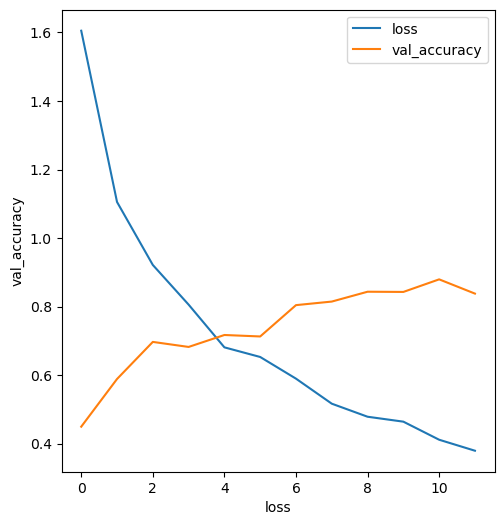

In [33]:
# plot the graph for 3rd model
#Evaluate the Model
history = pd.read_csv('hisr3.csv') 
history.head()
plt.figure(figsize=(19,6))
plt.subplot(131)
plt.plot(history.epoch, history.loss, label="loss")
plt.plot(history.epoch, history.val_accuracy, label="val_accuracy")
plt.xlabel('loss')
plt.ylabel('val_accuracy')
plt.legend()

In [34]:
from sklearn.metrics import accuracy_score,classification_report,confusion_matrix
#predict
y_pred=model3.predict(test_x)
y_pred=np.argmax(y_pred,axis=1)

#get confusion matrix
test_y_arg=np.argmax(test_y,axis=1)
#print('Confusion Matrix')
#print(confusion_matrix(test_y_arg, y_pred))
#print()
#print(',,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,')
#print()
#get classification report
#print(classification_report(y_pred,test_y_arg))

103/103 [==============================] - 10s 98ms/step


In [35]:
from keras.models import load_model
from sklearn.metrics import accuracy_score
model1=load_model('saved_models/model1.hdf5')
model2=load_model('saved_model/model2.hdf5')
model3=load_model('saved_models/model3.hdf5')
models=[model1,model2,model3]

In [36]:
preds=[model.predict(test_x) for model in models]
preds=np.array(preds)
summed=np.sum(preds,axis=0)
ensemble_prediction = np.argmax(summed,axis=1)

103/103 [==============================] - 10s 98ms/step


In [37]:
prediction1=model1.predict(test_x)
prediction2=model2.predict(test_x)
prediction3=model3.predict(test_x)

103/103 [==============================] - 11s 104ms/step


In [38]:
#argamx across classes
esemble_prediction=np.argmax(summed,axis=1)
esemble_prediction = np_utils.to_categorical(esemble_prediction,6)
prediction1=np.array(prediction1)
prediction2=np.array(prediction2)
prediction3=np.array(prediction3)
test_y_arg=np.argmax(test_y,axis=1)


In [39]:
print("model1 confusion matrics")
print(confusion_matrix(np.argmax(test_y, axis=1), np.argmax(prediction1, axis=1)))
#classification_report(np.argmax(test_y, axis=1), np.argmax(prediction1, axis=1))
print(',,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,')
print("model2 confusion matrics")
print(confusion_matrix(np.argmax(test_y, axis=1), np.argmax(prediction2, axis=1)))
print(',,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,')
print("model3 confusion matrics")
print(confusion_matrix(np.argmax(test_y, axis=1), np.argmax(prediction3, axis=1)))

model1 confusion matrics
[[344   6   3 123   6  34]
 [  0 441   2  14   2  12]
 [ 45   1  27 222   8 116]
 [ 36   3   0 559  81  21]
 [  0   2   0   4 671   1]
 [ 11   7   0 134  46 289]]
,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
model2 confusion matrics
[[410   0  27  68   2   9]
 [  1 427   4   3  22  14]
 [ 17   0 357  23   2  20]
 [ 64   0   6 555   4  71]
 [  3   0   0   7 664   4]
 [  6   5  41  52  13 370]]
,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
model3 confusion matrics
[[321   0  35 125   1  34]
 [  3 386   6  18  15  43]
 [ 11   1 316  42   3  46]
 [ 19   0   0 639   1  41]
 [  1   2   0   5 670   0]
 [  1   0  11  59   7 409]]


In [40]:
print("esemble_model confusion matrics")
print(confusion_matrix(np.argmax(test_y, axis=1), np.argmax(esemble_prediction, axis=1)))

esemble_model confusion matrics
[[383   0  13  93   3  24]
 [  1 446   1   8   5  10]
 [  9   0 307  78   4  21]
 [ 25   0   0 645   3  27]
 [  1   0   0   3 674   0]
 [  1   1  13  53  14 405]]


In [41]:
print(classification_report(np.argmax(test_y, axis=1), np.argmax(prediction1, axis=1)))
print(',,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,')
print(classification_report(np.argmax(test_y, axis=1), np.argmax(prediction2, axis=1)))
print(',,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,')
print(classification_report(np.argmax(test_y, axis=1), np.argmax(prediction3, axis=1)))
print(',,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,')
print("Esemble learning classification report")
print(classification_report(np.argmax(test_y, axis=1), np.argmax(esemble_prediction, axis=1)))

              precision    recall  f1-score   support

           0       0.79      0.67      0.72       516
           1       0.96      0.94      0.95       471
           2       0.84      0.06      0.12       419
           3       0.53      0.80      0.64       700
           4       0.82      0.99      0.90       678
           5       0.61      0.59      0.60       487

    accuracy                           0.71      3271
   macro avg       0.76      0.67      0.65      3271
weighted avg       0.75      0.71      0.68      3271

,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
              precision    recall  f1-score   support

           0       0.82      0.79      0.81       516
           1       0.99      0.91      0.95       471
           2       0.82      0.85      0.84       419
           3       0.78      0.79      0.79       700
           4       0.94      0.98      0.96       678
           5       0.76      0.76      0.76       487

    accuracy    

#getting accuracy of first model
#y_pred=model1.predict(test_x) 
y_pred=np.argmax(y_pred, axis=1)
y_test=np.argmax(test_y, axis=1)
accuracy1=accuracy_score(y_test,prediction1)

In [42]:
score = model1.evaluate(test_x, test_y, verbose = 1 )
print("Test Score: ", score[0])
print("Test accuracy: ", score[1])
print(',,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,')
score = model2.evaluate(test_x, test_y, verbose = 1 )
print("Test Score: ", score[0])
print("Test accuracy: ", score[1])
print(',,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,')
score = model3.evaluate(test_x, test_y, verbose = 1 )
print("Test Score: ", score[0])
print("Test accuracy: ", score[1])

103/103 [==============================] - 79s 747ms/step - loss: 1.3868 - accuracy: 0.7126
Test Score:  1.3867661952972412
Test accuracy:  0.7126260995864868
,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
103/103 [==============================] - 38s 364ms/step - loss: 0.4381 - accuracy: 0.8508
Test Score:  0.4380894899368286
Test accuracy:  0.850810170173645
,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
103/103 [==============================] - 11s 107ms/step - loss: 0.4479 - accuracy: 0.8380
Test Score:  0.4478748142719269
Test accuracy:  0.8379700183868408


In [43]:
ensemble_accuracy = accuracy_score(test_y,esemble_prediction)
print(ensemble_accuracy)

0.8743503515744421


In [44]:
#Now design algorithm for ensemble learning using meta data and above 2 model.
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.layers import Input, Average
model1 = load_model('saved_models/model1.hdf5')
model_1 = Model(inputs=model1.inputs,
                outputs=model1.outputs,
                name='name_of_model_1')
model2 = load_model('saved_model/model2.hdf5')
model_2 = Model(inputs=model2.inputs,
                outputs=model2.outputs,
                name='name_of_model_2')
model3 = load_model('saved_models/model3.hdf5')
model_3 = Model(inputs=model3.inputs,
                outputs=model3.outputs,
                name='name_of_model_3')
models = [model_1, model_2,model_3]
model_input = Input(shape=(100, 100, 1))
model_outputs = [model(model_input) for model in models]
ensemble_output = Average()(model_outputs)
ensemble_model = Model(inputs=model_input, outputs=ensemble_output, name='ensemble')

In [45]:
from keras.models import load_model
from sklearn.metrics import accuracy_score
#model1=load_model('saved_models/model.hdf5')
#model2=load_model('saved_model/model2.hdf5')
#model2=load_model('saved_models/model2.hdf5')
#models=[model,model2,model3]

preds= [model.predict(test_x) for model in models]
preds = np.array(preds)
summed =np.sum(preds,axis=0)

103/103 [==============================] - 11s 104ms/step


In [46]:
#esemble learning using weighted average of different model

In [47]:
models=[model1,model2,model3]
preds = [model.predict(test_x) for model in models]
preds=np.array(preds)

103/103 [==============================] - 10s 97ms/step


In [48]:
prediction3=model3.predict(test_x)
#argamx across classes
esemble_prediction=np.argmax(summed,axis=1)
esemble_prediction = np_utils.to_categorical(esemble_prediction,6)

103/103 [==============================] - 10s 101ms/step


In [49]:
weights=[0.2,0.4,0.4]
#weighted_preds = np.tensordot(preds.transpose((1, 2, 0)), weights, axes=((0),(0)))
weighted_preds = np.tensordot(preds,weights,axes=((0),(0))).shape
weighted_ensemble_prediction = np.argmax(weighted_preds,axis=0)
weighted_accuracy = accuracy_score(test_y,weighted_ensemble_prediction)
print(weighted_accuracy)

InvalidParameterError: The 'y_pred' parameter of accuracy_score must be an array-like or a sparse matrix. Got 0 instead.

In [ ]:
# Stack the predictions
stacked_predictions = np.hstack((prediction1, prediction2, prediction3))

# Define the meta-learner
meta_learner = Sequential([
    Dense(64, activation='relu', input_shape=(30,)),
    Dense(10, activation='softmax')
])

# Compile and train the meta-learner
meta_learner.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
meta_learner.fit(stacked_predictions, y_test, batch_size=64, epochs=5)

# Generate predictions using the stacked ensemble
stensemble_predictions = meta_learner.predict(stacked_predictions)

# Evaluate the ensemble accuracy
ensemble_accuracy = accuracy_score(np.argmax(y_test, axis=1), np.argmax(stensemble_predictions, axis=1))
print("Ensemble Accuracy:", ensemble_accuracy)

In [1]:
from keras.models import load_model
from sklearn.metrics import accuracy_score
model1=load_model('saved_models/model1.hdf5')
model2=load_model('saved_model/model2.hdf5')
model3=load_model('saved_models/model3.hdf5')
models=[model1,model2,model3]

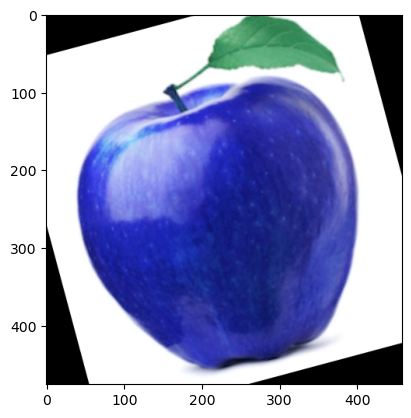

Types of fruits found:  6


In [3]:
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt
import os
import cv2 as cv
from tqdm import tqdm

#loading images from path
DATADIR = 'C:/Users/divya/Desktop/set 2/archive2/dataset/train'
CATEGORIES = ["freshapples","freshbanana","freshoranges","rottenapples","rottenbanana","rottenoranges"]
for category in CATEGORIES:
    path = os.path.join(DATADIR, category)
    for img in os.listdir(path):
        img_array = cv.imread(os.path.join(path,img))
        #,cv2.IMREAD_GRAYSCALE
        plt.imshow(img_array)
        plt.show()
        break
    break
#print (room_types)  #what kinds of rooms are in this dataset

print("Types of fruits found: ", len(CATEGORIES))


In [8]:
IMG_SIZE = 100
batch_size = 100
img_height = 100
img_width = 100
#building our training data
training_data = []

def create_training_data():
    for category in CATEGORIES:  # do fruits

        path = os.path.join(DATADIR,category)  # create path to fruits
        class_num = CATEGORIES.index(category)  # get the classification  (0 ,1,2,3,4,5,6) different number donate different category of fruit

        for img in tqdm(os.listdir(path)):  # iterate over each image per fruits
            try:
                img_array = cv.imread(os.path.join(path,img) ,cv.IMREAD_GRAYSCALE)  # convert to array
                new_array = cv.resize(img_array, (IMG_SIZE, IMG_SIZE))  # resize to normalize data size
                training_data.append([new_array, class_num])  # add this to our training_data
            except Exception as e:  # in the interest in keeping the output clean...
                pass        

create_training_data()

image_count = len(training_data)

100%|██████████████████████████████████████████| 1595/1595 [00:05<00:00, 308.29it/s]


In [9]:
#Assigning labels and features
X =[]
y =[]
for features, label in training_data:
    X.append(features)
    y.append(label)
X = np.array(X).reshape(-1, IMG_SIZE, IMG_SIZE, 1)

In [10]:
#creating own model
#Normalising X and converting labels to categorical data
from keras.utils import np_utils
X = X.astype('float32')
X /= 255
Y = np_utils.to_categorical(y,6)
#print(Y[100])
print(Y.shape)

(10901, 6)


In [28]:
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
X, Y = shuffle(X, Y, random_state=1)
train_x, test_x, train_y, test_y = train_test_split(X, Y, test_size=0.2, random_state=42)

In [29]:
prediction1=model1.predict(test_x)
prediction2=model2.predict(test_x)
prediction3=model3.predict(test_x)

69/69 [==============================] - 8s 110ms/step


In [34]:
from sklearn.model_selection import GridSearchCV
# Create the input for the meta-model by combining the predictions of the base models
stacked_predictions = np.column_stack((prediction1, prediction2, prediction3))

# Define the meta-model (Random Forest Classifier) and its hyperparameters for tuning
meta_model = RandomForestClassifier()
param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [None, 5, 10],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

# Perform hyperparameter tuning using GridSearchCV
grid_search = GridSearchCV(meta_model, param_grid, cv=5)
grid_search.fit(stacked_predictions, test_y)

# Retrieve the best hyperparameters
best_params = grid_search.best_params_

# Train the meta-model on the stacked predictions with the best hyperparameters
meta_model = RandomForestClassifier(**best_params)
meta_model.fit(stacked_predictions, test_y)

# Make final predictions using the meta-model
final_pred = meta_model.predict(stacked_predictions)

# Evaluate the accuracy of the stacking ensemble
accuracy = accuracy_score(test_y, final_pred)
print("Accuracy of stacking ensemble:", accuracy)

Accuracy of stacking ensemble: 0.9922054103622192


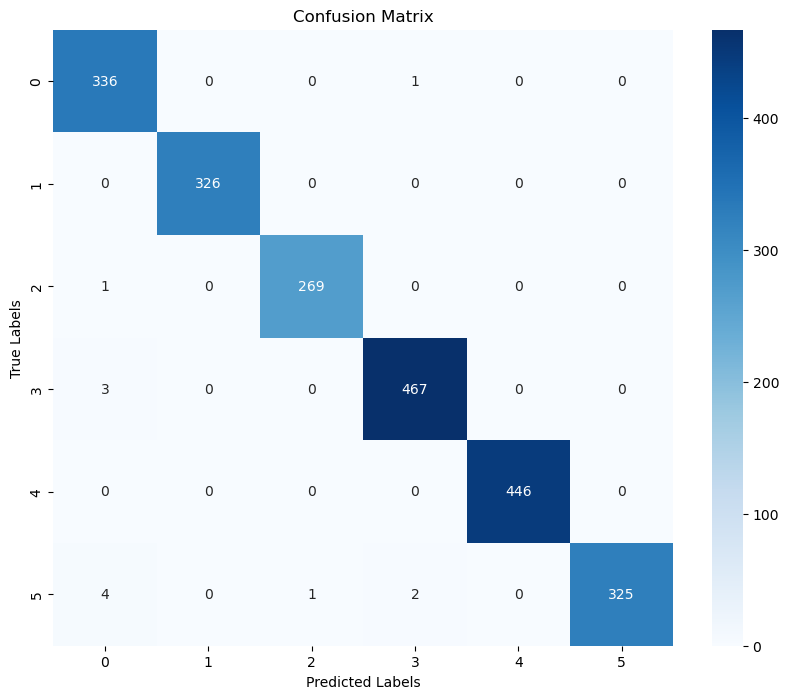

Classification Report:
              precision    recall  f1-score   support

           0       0.98      1.00      0.99       337
           1       1.00      1.00      1.00       326
           2       1.00      1.00      1.00       270
           3       0.99      0.99      0.99       470
           4       1.00      1.00      1.00       446
           5       1.00      0.98      0.99       332

    accuracy                           0.99      2181
   macro avg       0.99      0.99      0.99      2181
weighted avg       0.99      0.99      0.99      2181



In [35]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report

# Assuming you have the true labels in y_test and the final predictions in final_pred

# Flatten the true labels and final predictions
y_test_flat = np.argmax(test_y, axis=1)
final_pred_flat = np.argmax(final_pred, axis=1)

# Generate the confusion matrix
cm = confusion_matrix(y_test_flat, final_pred_flat)

# Create a heatmap for the confusion matrix
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
plt.title("Confusion Matrix")
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.show()

# Generate the classification report
report = classification_report(y_test_flat, final_pred_flat)
print("Classification Report:")
print(report)

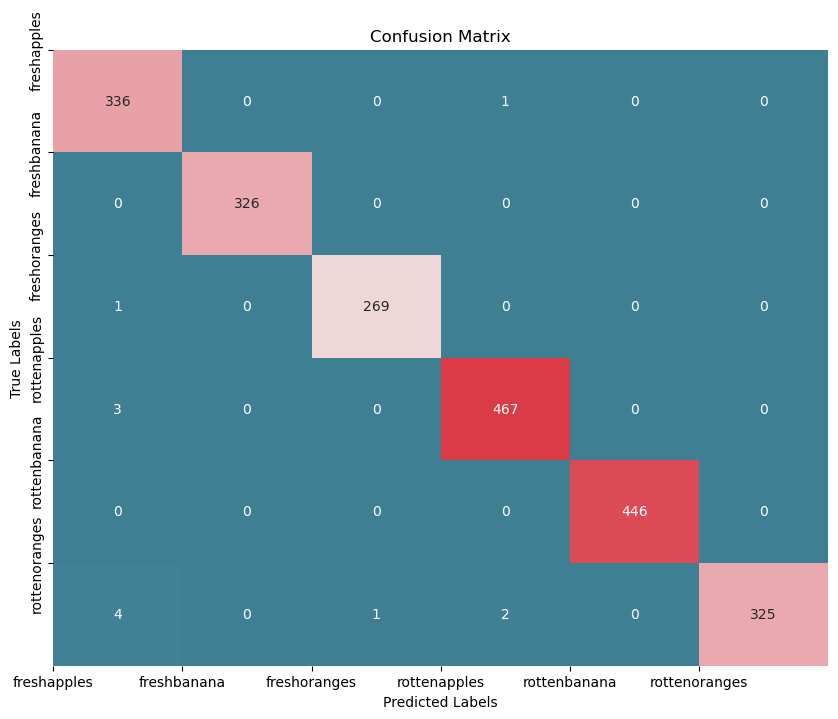

Classification Report:
               precision    recall  f1-score   support

  freshapples       0.98      1.00      0.99       337
  freshbanana       1.00      1.00      1.00       326
 freshoranges       1.00      1.00      1.00       270
 rottenapples       0.99      0.99      0.99       470
 rottenbanana       1.00      1.00      1.00       446
rottenoranges       1.00      0.98      0.99       332

     accuracy                           0.99      2181
    macro avg       0.99      0.99      0.99      2181
 weighted avg       0.99      0.99      0.99      2181



In [39]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report

# Assuming you have the true labels in y_test and the final predictions in final_pred

# Define the category labels
category_labels = ["freshapples", "freshbanana", "freshoranges", "rottenapples", "rottenbanana", "rottenoranges"]

# Flatten the true labels and final predictions
y_test_flat = np.argmax(test_y, axis=1)
final_pred_flat = np.argmax(final_pred, axis=1)

# Generate the confusion matrix
cm = confusion_matrix(y_test_flat, final_pred_flat)

# Calculate the maximum value in the confusion matrix
max_value = np.max(cm)

# Create a color map for the heatmap
cmap = sns.diverging_palette(220, 10, as_cmap=True)

# Create a heatmap for the confusion matrix with color intensity
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt="d", cmap=cmap, cbar=False, vmin=0, vmax=max_value)
plt.title("Confusion Matrix")
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.xticks(ticks=np.arange(len(category_labels)), labels=category_labels)
plt.yticks(ticks=np.arange(len(category_labels)), labels=category_labels)

plt.show()

# Generate the classification report
report = classification_report(y_test_flat, final_pred_flat, target_names=category_labels)
print("Classification Report:")
print(report)


In [30]:
import numpy as np
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
# Create the input for the meta-model by combining the predictions of the base models
stacked_predictions = np.column_stack((prediction1, prediction2, prediction3))

# Define the meta-model (can be any classifier of your choice)
meta_model = RandomForestClassifier()

# Train the meta-model on the stacked predictions
meta_model.fit(stacked_predictions, test_y)

# Make final predictions using the meta-model
final_pred = meta_model.predict(stacked_predictions)

# Evaluate the accuracy of the stacking ensemble
accuracy = accuracy_score(test_y, final_pred)
print("Accuracy of stacking ensemble:", accuracy)

Accuracy of stacking ensemble: 1.0


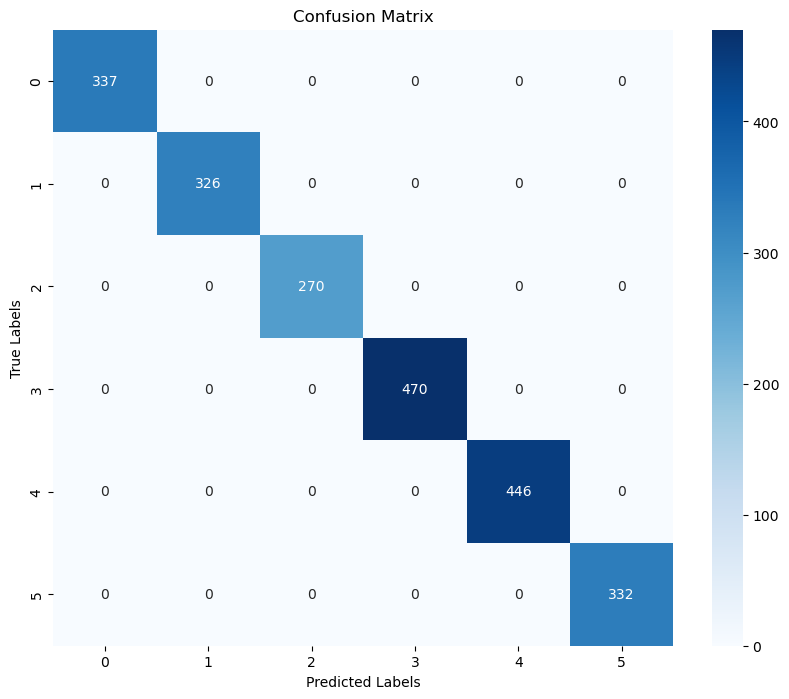

Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       337
           1       1.00      1.00      1.00       326
           2       1.00      1.00      1.00       270
           3       1.00      1.00      1.00       470
           4       1.00      1.00      1.00       446
           5       1.00      1.00      1.00       332

    accuracy                           1.00      2181
   macro avg       1.00      1.00      1.00      2181
weighted avg       1.00      1.00      1.00      2181



In [31]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report

# Assuming you have the true labels in y_test and the final predictions in final_pred

# Flatten the true labels and final predictions
y_test_flat = np.argmax(test_y, axis=1)
final_pred_flat = np.argmax(final_pred, axis=1)

# Generate the confusion matrix
cm = confusion_matrix(y_test_flat, final_pred_flat)

# Create a heatmap for the confusion matrix
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
plt.title("Confusion Matrix")
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.show()

# Generate the classification report
report = classification_report(y_test_flat, final_pred_flat)
print("Classification Report:")
print(report)